In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms, datasets

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, GPUStatsMonitor, ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

from pl_bolts.datamodules.cifar10_datamodule import CIFAR10DataModule
from pl_bolts.datamodules.imagenet_datamodule import ImagenetDataModule
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization, imagenet_normalization
from pl_bolts.optimizers.lr_scheduler import LinearWarmupCosineAnnealingLR

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [5]:
class Transform:
    def __init__(self, transform: A.Compose):
        self.transform = transform

    def __call__(self, img, *args, **kwargs):
        return self.transform(image=np.array(img), *args, **kwargs)

    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pl.seed_everything(42)

batch_size = 32
data_folder = "/home/dima/datasets/CIFAR10"

dm = CIFAR10DataModule(data_folder, batch_size=batch_size, shuffle=True)
dm.train_transforms = Transform(A.Compose([
    A.Normalize(mean=(0.491, 0.482, 0.447), std=(0.247, 0.244, 0.262)),
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    ToTensorV2(),
]))
dm.val_transforms = Transform(A.Compose([
    A.Normalize(mean=(0.491, 0.482, 0.447), std=(0.247, 0.244, 0.262)),
    ToTensorV2(),
]))
dm.test_transforms = Transform(A.Compose([
    A.Normalize(mean=(0.491, 0.482, 0.447), std=(0.247, 0.244, 0.262)),
    ToTensorV2(),
]))
dm.setup()

steps_per_epoch = len(dm.train_dataloader())

Global seed set to 42


In [6]:
class PatchEmbedding(nn.Module):
    """ 2D Image to Patch Embedding"""
    
    def __init__(self, img_size=224, patch_size=16, emb_dim=768, num_channels=3, norm_layer=None, dropout=0.):
        super().__init__()
        
        self.img_size = img_size = (img_size, img_size)
        self.patch_size = patch_size = (patch_size, patch_size)
        self.grid_size = (img_size[0] // patch_size[0], img_size[1] // patch_size[1])
        self.num_patches = self.grid_size[0] * self.grid_size[1]

        self.proj = nn.Conv2d(num_channels, emb_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = norm_layer(emb_dim) if norm_layer else nn.Identity()
        
        self.cls_token = nn.Parameter(torch.zeros(1, 1, emb_dim))
        self.pos_embedding = nn.Parameter(torch.zeros(1, 1 + self.num_patches, emb_dim))  # + cls_token
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        _, _, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x)
        x = rearrange(x, "b c h w -> b (h w) c")
        x = self.norm(x)
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = self.dropout(x + self.pos_embedding)
        return x

In [11]:
class VanillaViT(pl.LightningModule):
    def __init__(self, img_size=224, patch_size=16, emb_dim=512, depth=6, num_heads=8, 
                 num_channels=3, num_classes=10, dropout=0.1, emb_dropout=0.1, 
                 lr=1e-3, weight_decay=0, warmup=2*steps_per_epoch, max_iters=30*steps_per_epoch):
        super().__init__()
        
        self.save_hyperparameters()
        
        self.embedding = PatchEmbedding(img_size, patch_size, emb_dim, num_channels, dropout=emb_dropout)
        encoder_layer = nn.TransformerEncoderLayer(emb_dim, num_heads, dropout=dropout, 
                                                   activation='gelu', batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, depth)
        self.norm = nn.LayerNorm(emb_dim, eps=1e-6)
        self.classifier = nn.Linear(emb_dim, num_classes)
        
        self.train_acc = pl.metrics.Accuracy()
        self.val_acc = pl.metrics.Accuracy()
        self.test_acc = pl.metrics.Accuracy()
        
    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        x = self.norm(x)
        x = self.classifier(x[:, 0])
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x['image'])
        loss = F.cross_entropy(y_pred, y)
        self.log("train_loss", loss, on_step=True, on_epoch=True)
        self.log('train_acc', self.train_acc(y_pred, y), on_step=True, on_epoch=False, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x['image'])
        loss = F.cross_entropy(y_pred, y)
        self.log("val_loss", loss, on_step=False, on_epoch=True)
        self.log('val_acc', self.val_acc(y_pred, y), on_step=False, on_epoch=True, prog_bar=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x['image'])
        loss = F.cross_entropy(y_pred, y)
        self.log("test_loss", loss, on_step=False, on_epoch=True)
        self.log('test_acc', self.test_acc(y_pred, y), on_step=False, on_epoch=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay,
        )
        scheduler = LinearWarmupCosineAnnealingLR(optimizer, self.hparams.warmup, self.hparams.max_iters)
        scheduler_dict = {'scheduler': scheduler, 'interval': 'step'}
        return {'optimizer': optimizer, 'lr_scheduler': scheduler_dict}

In [12]:
model = VanillaViT(img_size=32, patch_size=8, lr=1e-4)
lr_monitor = LearningRateMonitor(logging_interval='step')
model_checkpoint = ModelCheckpoint(
    monitor='val_loss', 
    filename='cifar10-{epoch}-{val_loss:.3f}', 
    dirpath='/home/dima/ViTransformer/checkpoints/', 
    mode='min',
)
gpu_monitor = GPUStatsMonitor()

trainer = pl.Trainer(
    max_epochs=2,
    gpus=1,
    logger=TensorBoardLogger('/home/dima/lightning_logs/', name='vanilla_vit_cifar10'),
#     default_root_dir='/home/dima/vitransformer/checkpoints/',
    callbacks=[lr_monitor, model_checkpoint, gpu_monitor],
    gradient_clip_val=1,
)

trainer.fit(model, dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name        | Type               | Params
---------------------------------------------------
0 | embedding   | PatchEmbedding     | 108 K 
1 | transformer | TransformerEncoder | 18.9 M
2 | norm        | LayerNorm          | 1.0 K 
3 | classifier  | Linear             | 5.1 K 
4 | train_acc   | Accuracy           | 0     
5 | val_acc     | Accuracy           | 0     
6 | test_acc    | Accuracy           | 0     
---------------------------------------------------
19.0 M    Trainable params
0         Non-trainable params
19.0 M    Total params
76.114    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/dima/.cache/pypoetry/virtualenvs/vitransformer-feYZhwM1-py3.8/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


In [58]:
model_checkpoint.best_model_path

'/home/dima/ViTransformer/checkpoints/cifar10-epoch=0-val_loss=1.841.ckpt'

In [56]:
model.load_from_checkpoint(model_checkpoint.best_model_path)

VanillaViT(
  (embedding): PatchEmbedding(
    (proj): Conv2d(3, 512, kernel_size=(8, 8), stride=(8, 8))
    (norm): Identity()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLine

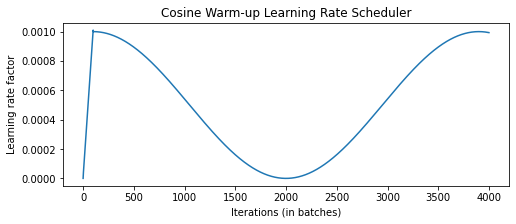

In [22]:
p = nn.Parameter(torch.empty(4,4))
optimizer = optim.Adam([p], lr=1e-3)
lr_scheduler = LinearWarmupCosineAnnealingLR(optimizer, 100, 2000)
# lr_scheduler = CosineWarmupScheduler(optimizer=optimizer, warmup=100, max_iters=2000)

# Plotting
epochs = list(range(4000))
lr = []
for _ in range(4000):
    lr.append(lr_scheduler.get_lr())
    lr_scheduler.step()
plt.figure(figsize=(8,3))
plt.plot(epochs, lr)
plt.ylabel("Learning rate factor")
plt.xlabel("Iterations (in batches)")
plt.title("Cosine Warm-up Learning Rate Scheduler")
plt.show()

In [77]:
def drop_path(x, drop_prob: float = 0., training: bool = False):
    """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).
    This is the same as the DropConnect impl I created for EfficientNet, etc networks, however,
    the original name is misleading as 'Drop Connect' is a different form of dropout in a separate paper...
    See discussion: https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956 ... I've opted for
    changing the layer and argument names to 'drop path' rather than mix DropConnect as a layer name and use
    'survival rate' as the argument.
    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output


class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)
    
    
class Mlp(nn.Module):
    """ MLP as used in Vision Transformer, MLP-Mixer and related networks"""
    
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x
    
    
class PatchEmbed(nn.Module):
    """ 2D Image to Patch Embedding"""
    
    def __init__(self, img_size=224, patch_size=16, num_channels=3, emb_dim=768, norm_layer=None):
        super().__init__()
        
        assert image_size % patch_size == 0, "Image dimensions must be divisible by the patch size"
        img_size = (img_size, img_size)
        patch_size = (patch_size, patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = (img_size[0] // patch_size[0], img_size[1] // patch_size[1])
        self.num_patches = self.grid_size[0] * self.grid_size[1]

        self.proj = nn.Conv2d(num_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = norm_layer(embed_dim) if norm_layer else nn.Identity()

    def forward(self, x):
        _, _, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x)
        x = rearrange(x, "b c h w -> b (h w) c")
        x = self.norm(x)
        return x

In [74]:
patch_embed = PatchEmbed(img_size=32, patch_size=8, embed_dim=512)
patches = patch_embed(images[0].unsqueeze(0))

True


In [ ]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x
    
    
class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

In [ ]:
class VisionTransformer(nn.Module):
    """ Vision Transformer
    A PyTorch impl of : `An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale`
        - https://arxiv.org/abs/2010.11929
    Includes distillation token & head support for `DeiT: Data-efficient Image Transformers`
        - https://arxiv.org/abs/2012.12877
    """

    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=True, representation_size=None, distilled=False,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0., embed_layer=PatchEmbed, norm_layer=None,
                 act_layer=None, weight_init=''):
        """
        Args:
            img_size (int, tuple): input image size
            patch_size (int, tuple): patch size
            in_chans (int): number of input channels
            num_classes (int): number of classes for classification head
            embed_dim (int): embedding dimension
            depth (int): depth of transformer
            num_heads (int): number of attention heads
            mlp_ratio (int): ratio of mlp hidden dim to embedding dim
            qkv_bias (bool): enable bias for qkv if True
            representation_size (Optional[int]): enable and set representation layer (pre-logits) to this value if set
            distilled (bool): model includes a distillation token and head as in DeiT models
            drop_rate (float): dropout rate
            attn_drop_rate (float): attention dropout rate
            drop_path_rate (float): stochastic depth rate
            embed_layer (nn.Module): patch embedding layer
            norm_layer: (nn.Module): normalization layer
            weight_init: (str): weight init scheme
        """
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        self.num_tokens = 2 if distilled else 1
        norm_layer = norm_layer or partial(nn.LayerNorm, eps=1e-6)
        act_layer = act_layer or nn.GELU

        self.patch_embed = embed_layer(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.dist_token = nn.Parameter(torch.zeros(1, 1, embed_dim)) if distilled else None
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + self.num_tokens, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.Sequential(*[
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, drop=drop_rate,
                attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer, act_layer=act_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)

        # Representation layer
        if representation_size and not distilled:
            self.num_features = representation_size
            self.pre_logits = nn.Sequential(OrderedDict([
                ('fc', nn.Linear(embed_dim, representation_size)),
                ('act', nn.Tanh())
            ]))
        else:
            self.pre_logits = nn.Identity()

        # Classifier head(s)
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()
        self.head_dist = None
        if distilled:
            self.head_dist = nn.Linear(self.embed_dim, self.num_classes) if num_classes > 0 else nn.Identity()

        self.init_weights(weight_init)

    def init_weights(self, mode=''):
        assert mode in ('jax', 'jax_nlhb', 'nlhb', '')
        head_bias = -math.log(self.num_classes) if 'nlhb' in mode else 0.
        trunc_normal_(self.pos_embed, std=.02)
        if self.dist_token is not None:
            trunc_normal_(self.dist_token, std=.02)
        if mode.startswith('jax'):
            # leave cls token as zeros to match jax impl
            named_apply(partial(_init_vit_weights, head_bias=head_bias, jax_impl=True), self)
        else:
            trunc_normal_(self.cls_token, std=.02)
            self.apply(_init_vit_weights)

    def _init_weights(self, m):
        # this fn left here for compat with downstream users
        _init_vit_weights(m)

    @torch.jit.ignore()
    def load_pretrained(self, checkpoint_path, prefix=''):
        _load_weights(self, checkpoint_path, prefix)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token', 'dist_token'}

    def get_classifier(self):
        if self.dist_token is None:
            return self.head
        else:
            return self.head, self.head_dist

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()
        if self.num_tokens == 2:
            self.head_dist = nn.Linear(self.embed_dim, self.num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        x = self.patch_embed(x)
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        if self.dist_token is None:
            x = torch.cat((cls_token, x), dim=1)
        else:
            x = torch.cat((cls_token, self.dist_token.expand(x.shape[0], -1, -1), x), dim=1)
        x = self.pos_drop(x + self.pos_embed)
        x = self.blocks(x)
        x = self.norm(x)
        if self.dist_token is None:
            return self.pre_logits(x[:, 0])
        else:
            return x[:, 0], x[:, 1]

    def forward(self, x):
        x = self.forward_features(x)
        if self.head_dist is not None:
            x, x_dist = self.head(x[0]), self.head_dist(x[1])  # x must be a tuple
            if self.training and not torch.jit.is_scripting():
                # during inference, return the average of both classifier predictions
                return x, x_dist
            else:
                return (x + x_dist) / 2
        else:
            x = self.head(x)
        return x


def _init_vit_weights(module: nn.Module, name: str = '', head_bias: float = 0., jax_impl: bool = False):
    """ ViT weight initialization
    * When called without n, head_bias, jax_impl args it will behave exactly the same
      as my original init for compatibility with prev hparam / downstream use cases (ie DeiT).
    * When called w/ valid n (module name) and jax_impl=True, will (hopefully) match JAX impl
    """
    if isinstance(module, nn.Linear):
        if name.startswith('head'):
            nn.init.zeros_(module.weight)
            nn.init.constant_(module.bias, head_bias)
        elif name.startswith('pre_logits'):
            lecun_normal_(module.weight)
            nn.init.zeros_(module.bias)
        else:
            if jax_impl:
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    if 'mlp' in name:
                        nn.init.normal_(module.bias, std=1e-6)
                    else:
                        nn.init.zeros_(module.bias)
            else:
                trunc_normal_(module.weight, std=.02)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
    elif jax_impl and isinstance(module, nn.Conv2d):
        # NOTE conv was left to pytorch default in my original init
        lecun_normal_(module.weight)
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    elif isinstance(module, (nn.LayerNorm, nn.GroupNorm, nn.BatchNorm2d)):
        nn.init.zeros_(module.bias)
        nn.init.ones_(module.weight)